In [2]:
import numpy as np

train_images = np.load('quickdraw_subset_np/train_images.npy')
train_labels = np.load('quickdraw_subset_np/train_labels.npy')
test_images = np.load('quickdraw_subset_np/test_images.npy')
test_labels = np.load('quickdraw_subset_np/test_labels.npy')


train_flat = train_images.reshape(train_images.shape[0], -1)
test_flat = test_images.reshape(test_images.shape[0], -1)
train_labels = train_labels.reshape(train_labels.shape[0], 1)
test_labels = test_labels.reshape(test_labels.shape[0], 1)
# PCA
#https://medium.com/technological-singularity/build-a-principal-component-analysis-pca-algorithm-from-scratch-7515595bf08b


def PCA_from_Scratch(X, n_components):
    X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-4)
    cov_mat = np.cov(X, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)  # Use eigh for symmetric matrices (covariance is symmetric)
    sort_indices = np.argsort(eigen_values)[::-1]
    principal_components = eigen_vectors[:, sort_indices[:n_components]]

    return principal_components


def transform(X, principal_components):
    X = X.copy()
    return X.dot(principal_components)



# LDA 
#https://www.kaggle.com/code/egazakharenko/linear-discriminant-analysis-lda-from-scratch
class LDA():
  def __init__(self, n_components=None):
     self.n_components = n_components
  def fit(self,X,y):
     self.X = X
     self.y = y
     samples = X.shape[0]
     features= X.shape[1]
     classes, cls_counts = np.unique(y,return_counts=True)
     priors = cls_counts/samples
     X_mean = np.array([X[y==cls].mean(axis=0) for cls in classes])
     betweenCLSdeviation = X_mean - X.mean(axis=0)
     withinCLSdeviation = X - X_mean[y]

     Sb = priors* betweenCLSdeviation.T @ betweenCLSdeviation
     Sw = withinCLSdeviation.T @ withinCLSdeviation / samples
     Sw_inv = np.linalg.pinv(Sw)
     eigvals, eigvecs = np.linalg.eig(Sw_inv @ Sb)
     self.dvecs = eigvecs[:, np.argsort(eigvals)[::-1]]
     self.weights = X_mean @ self.dvecs @ self.dvecs.T
     self.bias = np.log(priors) - 0.5 * np.diag(X_mean @ self.weights.T)
     if self.n_components is None:
        self.n_components = min(classes.size - 1, features)
  def transform(self, X):
    return X @ self.dvecs[:, : self.n_components]

  def predict(self, X_test):
    scores = X_test @ self.weights.T + self.bias
    return np.argmax(scores, axis=1)
  
def score(y_pred, y_true):
        accuracy = np.mean(y_pred == y_true)
        return accuracy

def macroF1(y_pred, y_true):
    labels = np.unique(y_true)
    f1_scores = []

    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_pred != label) & (y_true == label))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        f1_scores.append(f1)
    return np.mean(f1_scores)

print("1Starting...")

train_normal = train_flat/255
test_normal = test_flat/255
pcs = PCA_from_Scratch(train_normal, 128)
train_proj = transform(train_normal, pcs)
test_proj = transform(test_normal, pcs)
train_binary = (train_normal > 0.3).astype(int)
test_binary = (test_normal > 0.3).astype(int)

class KMeansClustering:
    def __init__(self, k, max_iter=1000,distance_metric='euclidean'):
        self.k = k
        self.max_iter = max_iter
        self.distance_metric = distance_metric
    
    def euclidean_distance(self, a, b):
        return np.linalg.norm(a - b, axis=0)
    
    def _manhattan(self, p1, p2):
        return np.sum(np.abs(p1 - p2))

    def cosine_distance(self, a, b):  
        denom = np.linalg.norm(a) * np.linalg.norm(b)
        if denom == 0:
            return 1.0  # maximal distance if one vector is zero
        return 1 - np.dot(a, b) / denom
    
    def _distance(self, a, b):
        if self.distance_metric == 'euclidean':
            return self.euclidean_distance(a, b)
        elif self.distance_metric == 'manhattan':
            return self._manhattan(a, b)
        elif self.distance_metric == 'cosine':
            return self.cosine_distance(a, b)
        
    def predict(self, X):
        distances = np.array([[self._distance(x, c) for c in self.centroids] for x in X])
        return np.argmin(distances, axis=1)
    
    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.centroids = X[np.random.choice(self.n_samples, self.k, replace=False)]
        self.labels = np.zeros(self.n_samples)
        new_centroids = np.zeros((self.k, self.n_features))
        for _ in range(self.max_iter):
            distances = np.array([[self._distance(x, c) for c in self.centroids] for x in X])
            self.labels = np.argmin(distances, axis=1)
            for i in range(self.k):
                members = X[self.labels == i]
                if len(members) == 0:
                    new_centroids[i] = X[np.random.randint(self.n_samples)]
                else:
                    new_centroids[i] = members.mean(axis=0)            
            if np.all(new_centroids == self.centroids):
                break
            
            self.centroids = new_centroids
        
        return self
    




1Starting...


In [3]:
import numpy as np

class KMeansPP:
    def __init__(self, k, max_iter=1000, distance_metric='euclidean', tol=1e-6):
        self.k = k
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.tol = tol
    
    def euclidean_distance(self, a, b):
        return np.linalg.norm(a - b)

    def manhattan_distance(self, a, b):
        return np.sum(np.abs(a - b))

    def cosine_distance(self, a, b):
        denom = np.linalg.norm(a) * np.linalg.norm(b)
        return 1 - np.dot(a, b) / denom if denom != 0 else 1.0

    def _distance(self, a, b):
        if self.distance_metric == 'euclidean':
            return self.euclidean_distance(a, b)
        elif self.distance_metric == 'manhattan':
            return self.manhattan_distance(a, b)
        elif self.distance_metric == 'cosine':
            return self.cosine_distance(a, b)
        else:
            raise ValueError(f"Unknown metric {self.distance_metric}")

    def _init_centroids_pp(self, X):
        """k-means++ initialization"""
        n_samples, _ = X.shape
        centroids = []
        # 1) choose first centroid uniformly at random
        first_idx = np.random.randint(n_samples)
        centroids.append(X[first_idx])

        # 2) choose remaining k-1 centroids
        for _ in range(1, self.k):
            # compute squared distances to nearest existing centroid
            dist_sq = np.array([
                min(self._distance(x, c)**2 for c in centroids)
                for x in X
            ])
            # pick next centroid weighted by dist_sq
            probs = dist_sq / dist_sq.sum()
            cumulative = np.cumsum(probs)
            r = np.random.rand()
            next_idx = np.searchsorted(cumulative, r)
            centroids.append(X[next_idx])
        
        return np.vstack(centroids)

    def fit(self, X):
        self.X = X
        n_samples, n_features = X.shape

        # initialize centroids with kmeans++
        self.centroids = self._init_centroids_pp(X)
        self.labels = np.zeros(n_samples, dtype=int)

        for it in range(self.max_iter):
            # 1) assign labels
            distances = np.array([
                [self._distance(x, c) for c in self.centroids]
                for x in X
            ])  # shape (n_samples, k)
            new_labels = np.argmin(distances, axis=1)

            # 2) compute new centroids
            new_centroids = np.zeros_like(self.centroids)
            for ci in range(self.k):
                members = X[new_labels == ci]
                if len(members) == 0:
                    # re-seed empty cluster
                    new_centroids[ci] = X[np.random.randint(n_samples)]
                else:
                    new_centroids[ci] = members.mean(axis=0)

            # 3) check convergence
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break

            self.centroids = new_centroids
            self.labels = new_labels

        return self

    def predict(self, X):
        distances = np.array([
            [self._distance(x, c) for c in self.centroids]
            for x in X
        ])
        return np.argmin(distances, axis=1)


In [4]:
def calinski_harabasz_score(X, labels):
    n_samples, n_features = X.shape
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    
    overall_mean = np.mean(X, axis=0)
    between_cluster_dispersion = 0
    within_cluster_dispersion = 0

    for label in unique_labels:
        cluster_points = X[labels == label]
        cluster_mean = np.mean(cluster_points, axis=0)
        between_cluster_dispersion += len(cluster_points) * np.sum((cluster_mean - overall_mean)**2)
        within_cluster_dispersion += np.sum((cluster_points - cluster_mean)**2)

    return (between_cluster_dispersion * (n_samples - k)) / (within_cluster_dispersion * (k - 1))

def davies_bouldin_score(X, labels):
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    cluster_means = np.array([np.mean(X[labels == label], axis=0) for label in unique_labels])
    cluster_sigs = np.array([np.mean(np.linalg.norm(X[labels == label] - cluster_means[i], axis=1)) for i, label in enumerate(unique_labels)])

    db_index = 0
    for i in range(k):
        max_ratio = -np.inf
        for j in range(k):
            if i != j:
                ratio = (cluster_sigs[i] + cluster_sigs[j]) / np.linalg.norm(cluster_means[i] - cluster_means[j])
                if ratio > max_ratio:
                    max_ratio = ratio
        db_index += max_ratio

    return db_index / k

In [6]:
distance = ['manhattan', 'euclidean', 'cosine']
dataset = [train_normal, train_normal]
testset = [test_normal, test_proj]
PCA = [32, 64, 128, 256]
# dataset = [ train_binary]
# testset = [ test_binary]

print("Distance Metric: Cosine")
print("PCA: ", train_normal)
# pcs = PCA_from_Scratch(train_normal, i)
# train_normal = transform(train_normal, pcs)
# test_proj = transform(test_normal, pcs)

km = KMeansClustering(k=5, max_iter=1000, distance_metric='cosine')
kmp = KMeansPP(k=5, max_iter=1000, distance_metric='cosine')
km.fit(train_normal)
kmp.fit(train_normal)

# SSE calculation
train_sse = np.sum([np.linalg.norm(x - km.centroids[km.labels[i]])**2 for i, x in enumerate(train_normal)])
train_sse2 = np.sum([np.linalg.norm(x - kmp.centroids[kmp.labels[i]])**2 for i, x in enumerate(train_normal)])
print("SSE KMeans: ", train_sse)
print("SSE KMeans++: ", train_sse2)

# Additional internal metrics
ch_score = calinski_harabasz_score(train_normal, km.labels)
ch_score2 = calinski_harabasz_score(train_normal, kmp.labels)
print("Calinski-Harabasz KMeans: ", ch_score)
print("Calinski-Harabasz KMeans++: ", ch_score2)

db_score = davies_bouldin_score(train_normal, km.labels)
db_score2 = davies_bouldin_score(train_normal, kmp.labels)
print("Davies-Bouldin KMeans: ", db_score)
print("Davies-Bouldin KMeans++: ", db_score2)

# Label mappings
mapping, mapping2 = {}, {}
for c in range(5):
    mask, mask2 = (km.labels == c), (kmp.labels == c)
    mapping[c] = np.bincount(train_labels[mask].flatten()).argmax() if np.any(mask) else -1
    mapping2[c] = np.bincount(train_labels[mask2].flatten()).argmax() if np.any(mask2) else -1

# External metrics
test_clusters = km.predict(test_normal)
test_clusters2 = kmp.predict(test_normal)

y_pred = np.array([mapping[c] for c in test_clusters])
y_pred2 = np.array([mapping2[c] for c in test_clusters2])

accuracy_km = score(y_pred.reshape(-1,1), test_labels)
accuracy_kmp = score(y_pred2.reshape(-1,1), test_labels)

print("KMeans Accuracy:     ", accuracy_km)
print("KMeans++ Accuracy:   ", accuracy_kmp)
print("KMeans Macro F1:     ", macroF1(y_pred.reshape(-1,1), test_labels))
print("KMeans++ Macro F1:   ", macroF1(y_pred2.reshape(-1,1), test_labels))


Distance Metric: Cosine
PCA:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
SSE KMeans:  1310605.1327276179
SSE KMeans++:  1274753.343903103
Calinski-Harabasz KMeans:  480.8239818081218
Calinski-Harabasz KMeans++:  634.9342104132764
Davies-Bouldin KMeans:  5.154203606822978
Davies-Bouldin KMeans++:  4.509499390859406
KMeans Accuracy:      0.4704
KMeans++ Accuracy:    0.5708
KMeans Macro F1:      0.35010317648606193
KMeans++ Macro F1:    0.5058033232715056


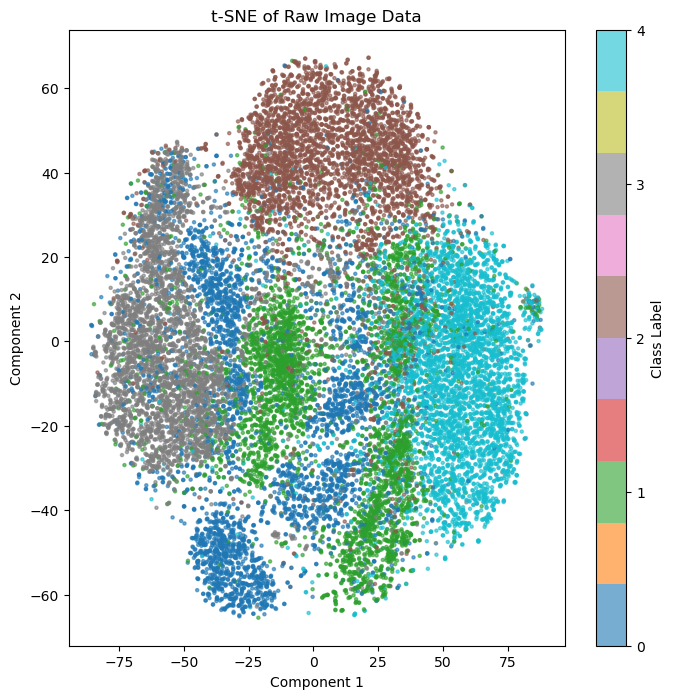

In [5]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1) Load data
train_images = np.load('quickdraw_subset_np/train_images.npy')
train_labels = np.load('quickdraw_subset_np/train_labels.npy')

# 2) Preprocess: flatten & scale
X = train_images.reshape(len(train_images), -1) / 255.0

# 3) t-SNE projection
tsne = TSNE(n_components=2, init='pca', random_state=42)
X_2d = tsne.fit_transform(X)

# 4) Scatter plot
plt.figure(figsize=(8,8))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=train_labels,
    cmap='tab10',
    s=5,
    alpha=0.6
)
plt.title('t-SNE of Raw Image Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, ticks=range(5), label='Class Label')
plt.show()
